In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-14 02:18:22.735753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 02:18:22.735785: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df = pd.read_csv('consumos_cst.csv', parse_dates=['date'])
df = df.set_index('date')
df = df.groupby('cst').resample('M').sum()

### Create batches of training data (12 months)

In [4]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [5]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=100, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [6]:
def train_predict(dataset, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(dataset, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    #print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)      
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 3)
        pred = scaler.inverse_transform(pred)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [7]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [8]:
def measure_error(actual, pred, step_in, step_out, index):
    print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [9]:
df1 = df.pivot_table('nr', 'date', 'cst')
df1 = df1.fillna(0)

In [10]:
dataset = df1[['Coimbra', 'Lisboa', 'Porto']].values
dataset = df1[['Coimbra', 'Lisboa', 'Porto']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
mae, rmse, smape = train_predict(dataset[:216], dataset[216:], df1[['Coimbra', 'Lisboa', 'Porto']][216:].values)

Epoch 1/500


2022-10-14 02:18:24.416259: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-14 02:18:24.416293: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-14 02:18:24.416569: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 14ms/step - loss: 0.4429
Epoch 2/500
7/7 [==============================] - 0s 14ms/step - loss: 0.3274
Epoch 3/500
7/7 [==============================] - 0s 11ms/step - loss: 0.1646
Epoch 4/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0705
Epoch 5/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0379
Epoch 6/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0237
Epoch 7/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0219
Epoch 8/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0208
Epoch 9/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0190
Epoch 10/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0185
Epoch 11/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0183
Epoch 12/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0183
Epoch 13/500
7/7 [==============================] - 0s 13ms/s

7/7 [==============================] - 0s 11ms/step - loss: 0.0134
Epoch 104/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0130
Epoch 105/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0134
Epoch 106/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0130
Epoch 107/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0128
Epoch 108/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0128
Epoch 109/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0130
Epoch 110/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0127
Epoch 111/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0125
Epoch 112/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0125
Epoch 113/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0124
Epoch 114/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0126
Epoch 115/500
7/7 [=======================

7/7 [==============================] - 0s 11ms/step - loss: 0.0105
Epoch 205/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0104
Epoch 206/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0106
Epoch 207/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0106
Epoch 208/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0112
Epoch 209/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0112
Epoch 210/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0106
Epoch 211/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0108
Epoch 212/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0109
Epoch 213/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0108
Epoch 214/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0110
Epoch 215/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0108
Epoch 216/500
7/7 [=======================

7/7 [==============================] - 0s 18ms/step - loss: 0.0102
Epoch 306/500
7/7 [==============================] - 0s 26ms/step - loss: 0.0100
Epoch 307/500
7/7 [==============================] - 0s 26ms/step - loss: 0.0103
Epoch 308/500
7/7 [==============================] - 0s 25ms/step - loss: 0.0099
Epoch 309/500
7/7 [==============================] - 0s 25ms/step - loss: 0.0100
Epoch 310/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0102
Epoch 311/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0101
Epoch 312/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0100
Epoch 313/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0101
Epoch 314/500
7/7 [==============================] - 0s 27ms/step - loss: 0.0098
Epoch 315/500
7/7 [==============================] - 0s 23ms/step - loss: 0.0097
Epoch 316/500
7/7 [==============================] - 0s 22ms/step - loss: 0.0098
Epoch 317/500
7/7 [=======================

7/7 [==============================] - 0s 19ms/step - loss: 0.0099
Epoch 407/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0095
Epoch 408/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0096
Epoch 409/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0100
Epoch 410/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0095
Epoch 411/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0095
Epoch 412/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0096
Epoch 413/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0097
Epoch 414/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0100
Epoch 415/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0094
Epoch 416/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0100
Epoch 417/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0103
Epoch 418/500
7/7 [=======================

[[3503. 8444. 3900.]
 [3602. 8008. 3873.]] [[3870.336  7247.1963 5396.9185]
 [3893.9048 7381.1836 5524.556 ]] 16 18
[[3850. 7833. 3679.]
 [3552. 7349. 3378.]] [[3905.356  7441.84   5349.1685]
 [3942.4443 7614.692  5482.9326]] 18 20
[[3114. 7298. 3182.]
 [3176. 8162. 3677.]] [[3692.7974 6999.906  5233.6206]
 [3668.0056 7119.1055 5309.8867]] 20 22
[[2943. 8397. 3936.]
 [2832. 7160. 3530.]] [[3560.6887 7035.8706 5253.2373]
 [3607.5156 7149.162  5405.0605]] 22 24
[[4243. 8579. 3650.]
 [3289. 7807. 3840.]] [[3472.045  6775.558  5182.635 ]
 [3467.439  6855.1235 5288.201 ]] 24 26
[[3317. 8292. 3832.]
 [3288. 8108. 3571.]] [[3543.423  6733.133  5356.198 ]
 [3523.867  6774.2456 5446.9146]] 26 28
[[3938. 8650. 4018.]
 [3564. 7417. 3210.]] [[3581.8818 6773.069  5299.0493]
 [3528.4902 6805.137  5346.1265]] 28 30
[[4155. 8182. 3938.]
 [3765. 7731. 3578.]] [[3754.1572 7094.7114 5234.3477]
 [3732.9763 7220.648  5322.0796]] 30 32
[[3736. 7736. 3575.]
 [3631. 9302. 4112.]] [[3723.2769 7024.868  5343.33

In [11]:
len(smape)

15

### Calculate Error

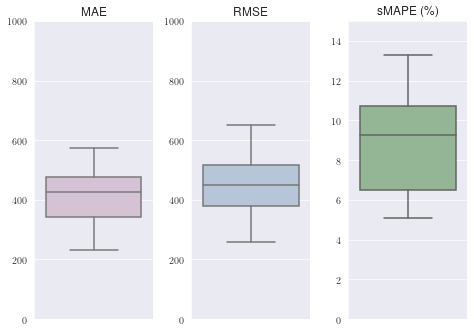

In [15]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 1000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 1000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 15))
plt.tight_layout()
plt.savefig('figures/demand_lstm_monthly_cst_multi_boxplot.pdf')

In [13]:
demand_lstm_month_cst_multi = [mae,rmse,smape]
%store demand_lstm_month_cst_multi